# Oracle & Orderbook Analysis

This notebook loads oracle and orderbook data from sim_data subdirectories, reconstructs orderbooks at each oracle timestamp, and creates a global DataFrame with:
- **MidPriceUp**: Mid price of the UP token orderbook
- **MidPriceDown**: Mid price of the DOWN token orderbook
- **BpsDifference**: `(price - threshold) / threshold * 10_000` from oracle data

In [39]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt

In [40]:
import bisect

class OrderbookReconstructor:
    """Reconstructs orderbook state from initial snapshot and incremental price changes."""
    
    def __init__(self, up_token_id: str, down_token_id: str, initial_snapshots: dict):
        self.up_token_id = up_token_id
        self.down_token_id = down_token_id
        
        # Initialize orderbooks from snapshots
        # Structure: {token_id: {'bids': {price: size}, 'asks': {price: size}}}
        self.orderbooks = {}
        for token_id, snapshot in initial_snapshots.items():
            self.orderbooks[token_id] = {
                'bids': {item['price']: item['size'] for item in snapshot.get('bids', [])},
                'asks': {item['price']: item['size'] for item in snapshot.get('asks', [])}
            }
    
    def apply_single_change(self, change: dict):
        """Apply a single price change to the orderbook."""
        asset_id = change['asset_id']
        price = change['price']
        size = change['size']
        side = 'bids' if change['side'] == 'buy' else 'asks'
        
        if asset_id not in self.orderbooks:
            self.orderbooks[asset_id] = {'bids': {}, 'asks': {}}
        
        if size == 0:
            # Remove price level
            self.orderbooks[asset_id][side].pop(price, None)
        else:
            # Update or add price level
            self.orderbooks[asset_id][side][price] = size
    
    def get_mid_price(self, token_id: str) -> Optional[float]:
        """Get mid price for a token: (best_bid + best_ask) / 2."""
        if token_id not in self.orderbooks:
            return None
        
        ob = self.orderbooks[token_id]
        bids = ob.get('bids', {})
        asks = ob.get('asks', {})
        
        if not bids or not asks:
            return None
        
        best_bid = max(bids.keys())
        best_ask = min(asks.keys())
        
        return (best_bid + best_ask) / 2
    
    def get_mid_price_up(self) -> Optional[float]:
        return self.get_mid_price(self.up_token_id)
    
    def get_mid_price_down(self) -> Optional[float]:
        return self.get_mid_price(self.down_token_id)

In [41]:
def process_sim_directory(dir_path: Path) -> pd.DataFrame:
    """Process a single sim_data subdirectory and return DataFrame with MidPriceUp, MidPriceDown, BpsDifference.
    
    Iterates over every price_change (ms precision) and looks up the corresponding oracle entry
    (most recent oracle with timestamp <= change timestamp) for each change.
    """
    oracle_path = dir_path / 'oracle.json'
    orderbooks_path = dir_path / 'orderbooks_raw.json'
    
    if not oracle_path.exists() or not orderbooks_path.exists():
        print(f"Skipping {dir_path.name}: missing required files")
        return pd.DataFrame()
    
    # Load data
    with open(oracle_path, 'r') as f:
        oracle_data = json.load(f)
    
    with open(orderbooks_path, 'r') as f:
        orderbooks_data = json.load(f)
    
    # Sort oracle by timestamp for binary search lookup
    oracle_data = sorted(oracle_data, key=lambda x: x['timestamp'])
    oracle_timestamps = [e['timestamp'] for e in oracle_data]
    
    # Sort price_changes by timestamp
    price_changes = sorted(orderbooks_data.get('price_changes', []), key=lambda x: x['timestamp'])
    
    # Initialize orderbook reconstructor from initial snapshots only
    reconstructor = OrderbookReconstructor(
        up_token_id=orderbooks_data['up_token_id'],
        down_token_id=orderbooks_data['down_token_id'],
        initial_snapshots=orderbooks_data['initial_snapshots']
    )
    
    rows = []
    for change in price_changes:
        change_ts = change['timestamp']
        
        # Apply this change to orderbook
        reconstructor.apply_single_change(change)
        
        # Find oracle entry valid at this timestamp (binary search)
        # bisect_right returns insertion point, so -1 gives us the last oracle <= change_ts
        oracle_idx = bisect.bisect_right(oracle_timestamps, change_ts) - 1
        if oracle_idx < 0:
            continue  # No oracle data yet
        
        oracle_entry = oracle_data[oracle_idx]
        
        # Calculate mid prices from current orderbook state
        mid_price_up = reconstructor.get_mid_price_up()
        mid_price_down = reconstructor.get_mid_price_down()
        
        # Calculate BpsDifference from oracle
        bps_diff = (oracle_entry['price'] - oracle_entry['threshold']) / oracle_entry['threshold'] * 10_000
        
        rows.append({
            'timestamp': change_ts,
            'MidPriceUp': mid_price_up,
            'MidPriceDown': mid_price_down,
            'OraclePrice': oracle_entry['price'],
            'Threshold': oracle_entry['threshold'],
            'BpsDifference': bps_diff,
            'source_dir': dir_path.name
        })
    
    return pd.DataFrame(rows)

In [42]:
# Main processing loop - load data from all sim_data subdirectories
# Path relative to src/model_tuning/ directory
sim_data_path = Path('../../sim_data')

all_dfs = []
for subdir in sorted(sim_data_path.iterdir()):
    if subdir.is_dir():
        print(f"Processing {subdir.name}...")
        df = process_sim_directory(subdir)
        if not df.empty:
            all_dfs.append(df)
            print(f"  -> {len(df)} rows")

# Concatenate all DataFrames
if all_dfs:
    global_df = pd.concat(all_dfs, ignore_index=True)
    rows_initial = len(global_df)
    
    # First pass: Remove exact duplicate rows (all columns including timestamp)
    global_df = global_df.drop_duplicates()
    rows_after_exact = len(global_df)
    
    # Second pass: Remove duplicates based on all columns except timestamp
    # Keep the first occurrence (earliest timestamp)
    cols_for_dedup = [c for c in global_df.columns if c != 'timestamp']
    global_df = global_df.drop_duplicates(subset=cols_for_dedup, keep='first')
    rows_final = len(global_df)
    
    print(f"\nTotal rows initial: {rows_initial}")
    print(f"After exact deduplication: {rows_after_exact} (removed {rows_initial - rows_after_exact})")
    print(f"After content deduplication: {rows_final} (removed {rows_after_exact - rows_final})")
else:
    global_df = pd.DataFrame()
    print("No data found")

Processing btc-updown-15m-1768543200...
  -> 59710 rows

Total rows initial: 59710
After exact deduplication: 27597 (removed 32113)
After content deduplication: 471 (removed 27126)


In [43]:
# Display DataFrame info and first rows
print("DataFrame columns:", global_df.columns.tolist())
print(f"\nShape: {global_df.shape}")
print(f"\nData types:\n{global_df.dtypes}")
print(f"\nFirst 10 rows:")
global_df

DataFrame columns: ['timestamp', 'MidPriceUp', 'MidPriceDown', 'OraclePrice', 'Threshold', 'BpsDifference', 'source_dir']

Shape: (471, 7)

Data types:
timestamp          int64
MidPriceUp       float64
MidPriceDown     float64
OraclePrice      float64
Threshold        float64
BpsDifference    float64
source_dir        object
dtype: object

First 10 rows:


,timestamp,MidPriceUp,MidPriceDown,OraclePrice,Threshold,BpsDifference,source_dir
0,1768543566000,0.825,0.175,95773.258415,95637.78781,14.164966,btc-updown-15m-1768543200
126,1768543566414,0.825,0.170,95773.258415,95637.78781,14.164966,btc-updown-15m-1768543200
127,1768543566414,0.830,0.170,95773.258415,95637.78781,14.164966,btc-updown-15m-1768543200
132,1768543566425,0.835,0.170,95773.258415,95637.78781,14.164966,btc-updown-15m-1768543200
133,1768543566425,0.835,0.165,95773.258415,95637.78781,14.164966,btc-updown-15m-1768543200
...,...,...,...,...,...,...,...
57818,1768543726848,0.555,0.455,95655.668938,95637.78781,1.869672,btc-updown-15m-1768543200
57819,1768543726848,0.545,0.455,95655.668938,95637.78781,1.869672,btc-updown-15m-1768543200
57922,1768543727000,0.545,0.455,95649.715295,95637.78781,1.247152,btc-updown-15m-1768543200
58738,1768543728001,0.545,0.455,95651.403359,95637.78781,1.423658,btc-updown-15m-1768543200


In [44]:
# Summary statistics
print("Summary Statistics:")
print("="*50)
global_df[['MidPriceUp', 'MidPriceDown', 'BpsDifference']].describe()

Summary Statistics:


,MidPriceUp,MidPriceDown,BpsDifference
count,471.000000,471.000000,471.000000
mean,0.717962,0.282166,8.742505
std,0.104793,0.105114,4.698690
min,0.545000,0.125000,1.247152
25%,0.632500,0.165000,4.346617
50%,0.675000,0.325000,7.646299
75%,0.835000,0.370000,13.757649
max,0.875000,0.455000,16.299889


In [45]:
# Verify mid prices are in valid range (0-1)
print("Validation:")
print("="*50)
print(f"MidPriceUp range: [{global_df['MidPriceUp'].min():.4f}, {global_df['MidPriceUp'].max():.4f}]")
print(f"MidPriceDown range: [{global_df['MidPriceDown'].min():.4f}, {global_df['MidPriceDown'].max():.4f}]")
print(f"BpsDifference range: [{global_df['BpsDifference'].min():.2f}, {global_df['BpsDifference'].max():.2f}]")
print(f"\nNull values:")
print(global_df[['MidPriceUp', 'MidPriceDown', 'BpsDifference']].isnull().sum())

Validation:
MidPriceUp range: [0.5450, 0.8750]
MidPriceDown range: [0.1250, 0.4550]
BpsDifference range: [1.25, 16.30]

Null values:
MidPriceUp       0
MidPriceDown     0
BpsDifference    0
dtype: int64


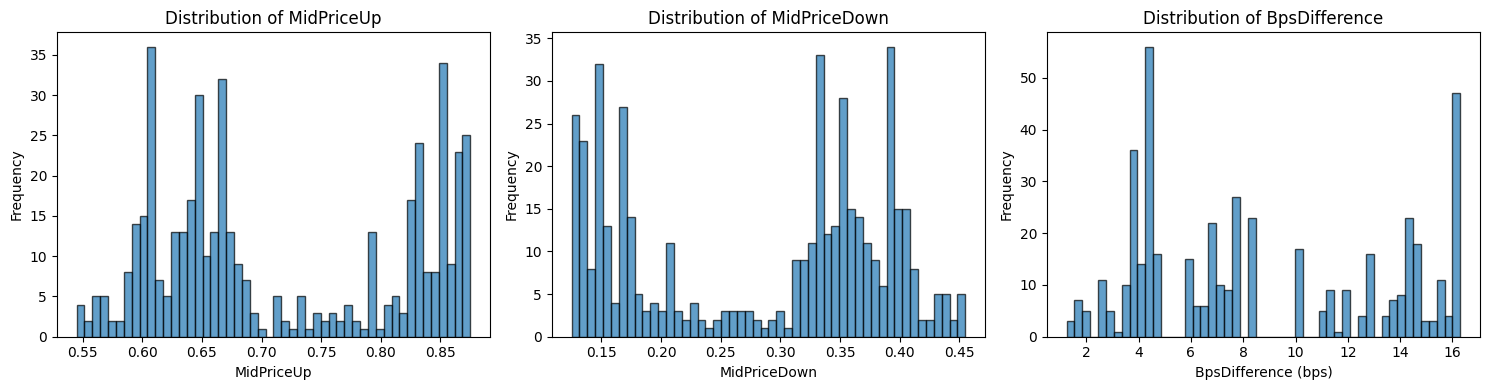

In [46]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(global_df['MidPriceUp'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('MidPriceUp')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of MidPriceUp')

axes[1].hist(global_df['MidPriceDown'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('MidPriceDown')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of MidPriceDown')

axes[2].hist(global_df['BpsDifference'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('BpsDifference (bps)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of BpsDifference')

plt.tight_layout()
plt.show()

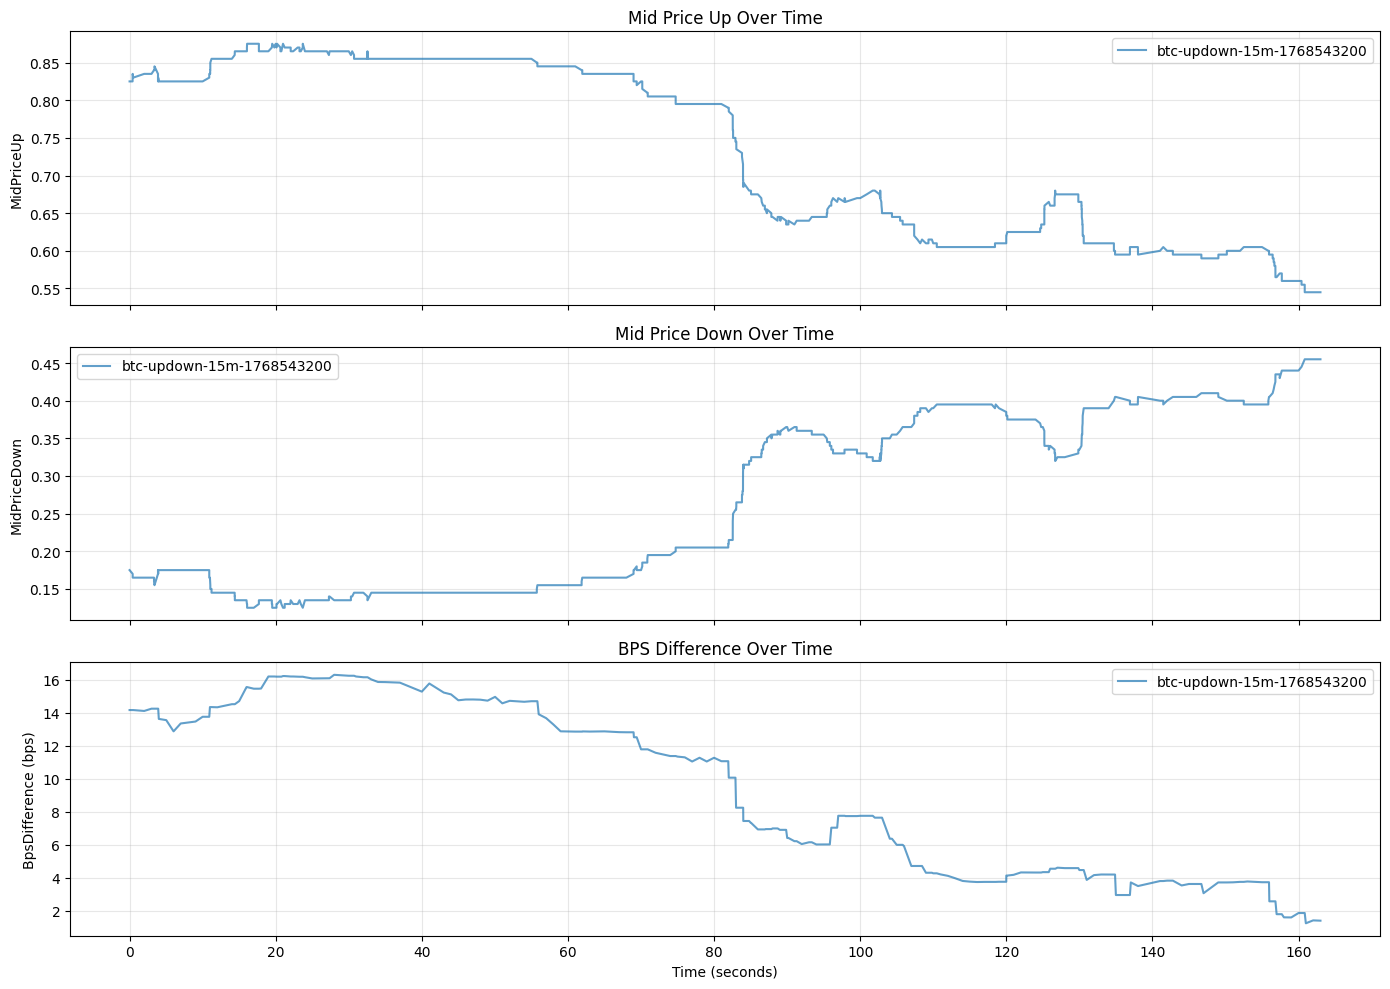

In [47]:
# Time series visualization (per source directory)
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for source in global_df['source_dir'].unique():
    subset = global_df[global_df['source_dir'] == source].copy()
    # Convert timestamp to relative seconds from start
    subset['time_sec'] = (subset['timestamp'] - subset['timestamp'].min()) / 1000
    
    axes[0].plot(subset['time_sec'], subset['MidPriceUp'], label=source, alpha=0.7)
    axes[1].plot(subset['time_sec'], subset['MidPriceDown'], label=source, alpha=0.7)
    axes[2].plot(subset['time_sec'], subset['BpsDifference'], label=source, alpha=0.7)

axes[0].set_ylabel('MidPriceUp')
axes[0].set_title('Mid Price Up Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_ylabel('MidPriceDown')
axes[1].set_title('Mid Price Down Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_ylabel('BpsDifference (bps)')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_title('BPS Difference Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()